In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchvision
import cv2

from utils.dataloader import ProteinDataset, ProteinExternalDataset, get_data_loaders, get_test_loader
from models.densenet import Atlas_DenseNet
from models.uselessnet import UselessNet
from utils.metrics import f1_score

In [3]:
train_labels_path = f"./data/train.csv"
test_submission_path = f"./data/sample_submission.csv"
train_images_path = f"./data/train/"
test_images_path = f"./data/test/"

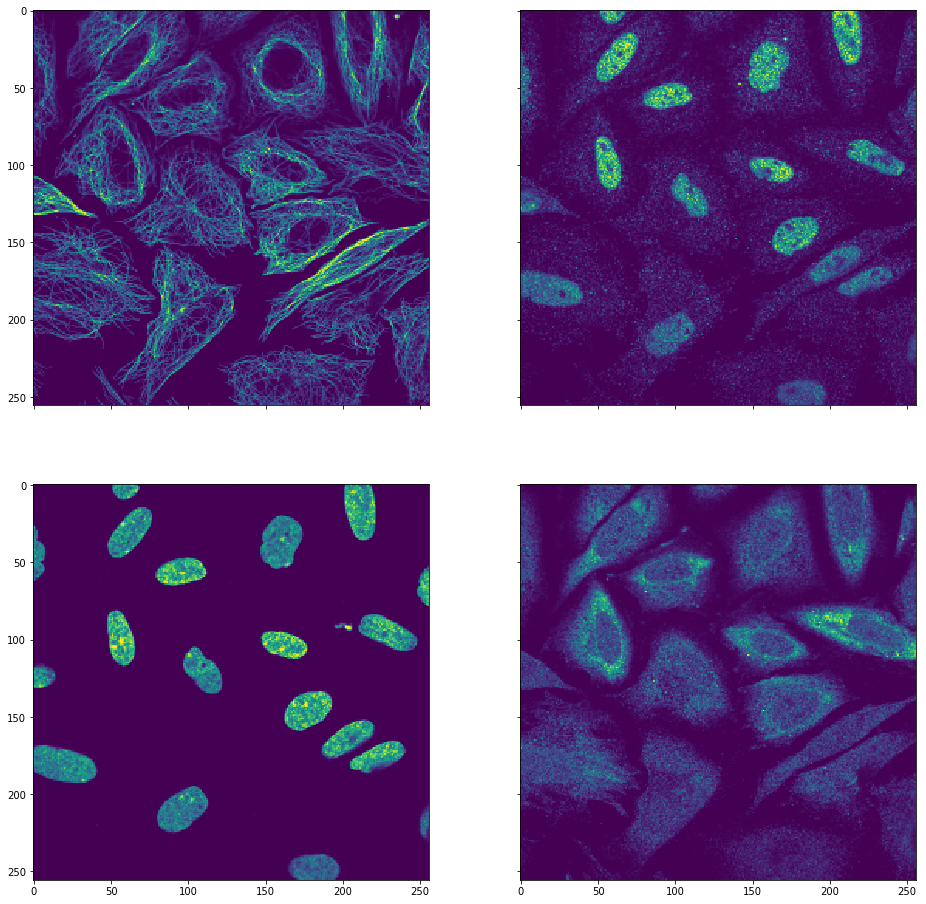

In [4]:
data = ProteinDataset()
_, axes = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(16, 16))
for i in range(4):
    axes[i // 2, i % 2].imshow(data[125][0][i, :, :].numpy())

In [5]:
e = ProteinExternalDataset()
_, axes = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(16, 16))
for i in range(4):
    axes[i // 2, i % 2].imshow(e[125][0][i, :, :].numpy())

FileNotFoundError: File b'./data/external_data_m/HPAv18RBGY_wodpl.csv' does not exist

In [6]:
d, e = get_data_loaders(imsize=512, test_size=0.8)

In [7]:
%%timeit
batch = next(iter(d))

1.32 s ± 98.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [58]:
t = get_test_loader(imsize=256)

In [61]:
batch = next(iter(t))

In [24]:
dn = torchvision.models.densenet121(pretrained=True)

In [27]:
dn.features

Sequential(
  (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace)
  (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (denseblock1): _DenseBlock(
    (denselayer1): _DenseLayer(
      (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace)
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace)
      (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (denselayer2): _DenseLayer(
      (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace)
      (conv1): Conv2d(96, 128, kernel_size=(1, 1), st

In [138]:
from torchvision.models import densenet121, densenet161, densenet169, densenet201

In [139]:
dnet = [densenet121, densenet169, densenet201, densenet161]

In [4]:
tdf = pd.read_csv(train_labels_path)

In [11]:
def label_gen(labelstr):
    label = np.zeros(28, dtype='uint8')
    labelstr = labelstr.split()
    for l in labelstr:
        label[int(l)]=1
    return label

In [12]:
tdf['labels'] = tdf['Target'].apply(label_gen)

In [17]:
from skmultilearn.model_selection import iterative_train_test_split

In [20]:
np.stack(tdf['labels']).shape

(31072, 28)

In [26]:
x = np.arange(len(tdf))

In [28]:
x[:, None].shape

(31072, 1)

In [30]:
x[:, None][5, :]

array([5])

In [32]:
Xt, yt, xtest, ytest = iterative_train_test_split(np.arange(len(tdf))[:, None], np.stack(tdf['labels']), test_size=0.2)

In [44]:
len(tdf)

31072

In [53]:
tdf.loc(3)

ValueError: No axis named 3 for object type <class 'pandas.core.frame.DataFrame'>

In [63]:
x.astype(np.float).dtype

dtype('float64')

In [56]:
tdf.loc[Xt.squeeze(1)]

,Id,Target,labels
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,002679c2-bbb6-11e8-b2ba-ac1f6b6435d0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
12,0032a07e-bba9-11e8-b2ba-ac1f6b6435d0,24 0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
13,00344514-bbc2-11e8-b2bb-ac1f6b6435d0,23,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
14,00357b1e-bba9-11e8-b2ba-ac1f6b6435d0,6 2,"[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
15,00383b44-bbbb-11e8-b2ba-ac1f6b6435d0,25,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
18,003feb6e-bbca-11e8-b2bc-ac1f6b6435d0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
19,0042017c-bba4-11e8-b2b9-ac1f6b6435d0,25 11,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
20,00456fd2-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0,"[1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."


In [43]:
tdf[Xt.squeeze(1)]

KeyError: '[    2     3     7 ... 27703 28934 30255] not in index'

In [121]:
from torchvision.models import resnet18, resnet34, resnet50, resnet101, resnet152

In [132]:
net = resnet18(pretrained=True)
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [126]:
nets = [resnet18, resnet34, resnet50, resnet101, resnet152]

In [139]:
net.conv1.weight.data.shape

torch.Size([64, 3, 7, 7])

In [140]:
for n in nets:
    net = n()
    print(net.conv1)
    print(net.fc)

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Linear(in_features=512, out_features=1000, bias=True)
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Linear(in_features=512, out_features=1000, bias=True)
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Linear(in_features=2048, out_features=1000, bias=True)
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Linear(in_features=2048, out_features=1000, bias=True)
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Linear(in_features=2048, out_features=1000, bias=True)


In [147]:
ti = torch.Tensor(10, 4, 256, 256)

In [154]:
net = Atlas_ResNet("resnet50", True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/litemax/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [01:51<00:00, 920622.13it/s]


Loading weights...


Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /home/litemax/.torch/models/resnet101-5d3b4d8f.pth
100%|██████████| 178728960/178728960 [03:37<00:00, 821774.91it/s] 


Loading weights...


Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /home/litemax/.torch/models/resnet152-b121ed2d.pth
100%|██████████| 241530880/241530880 [04:16<00:00, 939877.15it/s] 


Loading weights...


In [152]:
net(ti)

tensor([[ 0.9741,  1.0195, -0.1737, -0.0360,  1.2478, -0.2701, -0.8181, -0.2007,
         -0.0279,  0.4219, -0.0917, -0.3554, -0.1122,  0.5440,  0.3223, -1.1751,
          0.6428, -0.0953, -0.0649, -0.8347,  0.3658,  0.9306, -0.0194, -0.2520,
         -0.0691, -0.7061,  0.0696, -0.2375],
        [ 0.9741,  1.0195, -0.1737, -0.0360,  1.2478, -0.2701, -0.8181, -0.2007,
         -0.0279,  0.4219, -0.0917, -0.3554, -0.1122,  0.5440,  0.3223, -1.1751,
          0.6428, -0.0953, -0.0649, -0.8347,  0.3658,  0.9306, -0.0194, -0.2520,
         -0.0691, -0.7061,  0.0696, -0.2375],
        [ 0.9741,  1.0195, -0.1737, -0.0360,  1.2478, -0.2701, -0.8181, -0.2007,
         -0.0279,  0.4219, -0.0917, -0.3554, -0.1122,  0.5440,  0.3223, -1.1751,
          0.6428, -0.0953, -0.0649, -0.8347,  0.3658,  0.9306, -0.0194, -0.2520,
         -0.0691, -0.7061,  0.0696, -0.2375],
        [ 0.9741,  1.0195, -0.1737, -0.0360,  1.2478, -0.2701, -0.8181, -0.2007,
         -0.0279,  0.4219, -0.0917, -0.3554, -0.1122

In [5]:
from pretrainedmodels.models import bninception

In [16]:
from models.bninception import Atlas_BNInception
net = Atlas_BNInception(pretrained=True)

Using BN Inception
Loading weights...


In [20]:
t2 = torch.rand(10, 4, 256, 256)
t5 = torch.Tensor(10, 4, 512, 512)

In [17]:
bna = net(t2)
bna

tensor([[ 0.2320, -0.0382, -0.7546, -0.1447, -0.5254,  0.1923, -0.0925,  0.4096,
         -0.6172, -0.4036, -0.1989,  0.3390,  0.3182, -0.2514, -0.2055, -0.3227,
         -0.1161,  0.1771, -0.3830, -0.2923, -0.1175, -0.5203,  0.4451, -0.2568,
          0.8034, -0.2010, -0.7242, -0.0782],
        [ 0.0076, -0.1859, -0.2465, -0.0802, -0.1119, -0.1389,  0.6531, -0.4081,
          1.0611, -0.6590,  0.2807, -0.0178,  0.0275,  0.3132,  0.6636,  0.3822,
         -0.3233, -0.6503,  0.1949,  0.4441, -0.2427,  0.1413, -0.0170,  0.0108,
         -0.6984, -0.2713,  0.6595, -0.6261],
        [ 0.4871, -0.7588,  0.2601,  0.6654, -0.0358,  0.5876,  0.6202,  0.4340,
         -0.4455, -0.1518, -0.5034,  0.1225,  0.8027, -0.2455, -0.3242, -0.2561,
         -0.0981, -0.0618, -0.9134,  0.4086, -0.6780, -0.2354, -0.1623,  0.3905,
          0.0609, -0.3203,  0.0396, -0.5899],
        [-0.3140,  0.1383, -0.5097,  0.3437,  0.1680, -0.5712, -0.2168,  0.3609,
          0.4799,  0.6201,  0.4363, -0.3553,  0.0362

In [23]:
net(t5).shape

torch.Size([10, 28])

In [45]:
from models.wide_resnet_cifar_attention import WideResNetAttention

In [4]:
net = WideResNetAttention(34, 1, 28, 0, 
                                3, 1, 
                                0.001, "softmax")
net.train()

Attention after groups [2, 1, 0]


WideResNetAttention(
  (conv0): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (group_0): Group(
    (block_0): Block(
      (conv0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (block_1): Block(
      (conv0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_

In [5]:
MODEL_CKPT = './model_weights/best_WideResNetAttention_run33.pth'

In [6]:
net.load_state_dict(torch.load(MODEL_CKPT)['state_dict'])

In [8]:
ck = torch.load(MODEL_CKPT)

In [9]:
ck

{'epoch': 104,
 'arch': 'WideResNetAttention',
 'state_dict': OrderedDict([('conv0.weight',
               tensor([[[[ -0.8413,   0.3517,   1.3507],
                         [ -1.0439,  -0.9871,   1.0076],
                         [  0.1134,   0.6151,   2.1384]],
               
                        [[  1.5813,  -7.5062,  -1.6961],
                         [-12.1770, -16.4573,  -6.9067],
                         [ 10.8843, -16.6503,  -6.1079]],
               
                        [[  0.6891,   1.0234,  -1.0586],
                         [ -0.3991,   0.3785,   0.5067],
                         [  0.9092,   0.6875,  -0.3529]],
               
                        [[ -0.9102,  -0.4292,   2.3512],
                         [ -0.2179,  -0.3259,  -0.2655],
                         [  1.8542,   0.2842,  -0.8564]]],
               
               
                       [[[  0.9756,  -0.1297,   1.6351],
                         [ -1.2591,  -2.0669,   0.9052],
                         

In [22]:
d = ProteinDataset()

In [27]:
d[0]

(tensor([[[0.0127, 0.0000, 0.0010,  ..., 0.0049, 0.0392, 0.0157],
          [0.0020, 0.0029, 0.0000,  ..., 0.0039, 0.0490, 0.0353],
          [0.0029, 0.0000, 0.0000,  ..., 0.0363, 0.0216, 0.0794],
          ...,
          [0.0059, 0.0098, 0.0490,  ..., 0.0196, 0.0147, 0.0373],
          [0.0127, 0.0225, 0.0206,  ..., 0.0637, 0.0441, 0.0176],
          [0.0186, 0.0441, 0.0029,  ..., 0.0196, 0.0245, 0.0176]],
 
         [[0.0373, 0.0696, 0.0422,  ..., 0.0490, 0.0275, 0.0000],
          [0.1353, 0.0980, 0.0824,  ..., 0.0324, 0.0402, 0.0088],
          [0.1010, 0.0961, 0.1167,  ..., 0.0843, 0.0000, 0.0392],
          ...,
          [0.0039, 0.0294, 0.0216,  ..., 0.0314, 0.0157, 0.0000],
          [0.0255, 0.0245, 0.0422,  ..., 0.0284, 0.0088, 0.0049],
          [0.0343, 0.0157, 0.0186,  ..., 0.0167, 0.0049, 0.0245]],
 
         [[0.0118, 0.0549, 0.0431,  ..., 0.0333, 0.0382, 0.0000],
          [0.0451, 0.0392, 0.0324,  ..., 0.0402, 0.0098, 0.0000],
          [0.0461, 0.0176, 0.0343,  ...,

In [29]:
a,b = net(t2)

In [30]:
print(a+3.5)
print(b)

tensor([[-0.2795,  0.0762, -0.0633,  0.1582,  0.3240,  0.2579,  0.2607,  0.2211,
          0.0055,  0.0979,  0.1144, -0.1540, -0.0836,  0.1091,  0.4517,  0.1271,
          0.3337,  0.1590,  0.3005,  0.1072,  0.1767,  0.1387,  0.0871,  0.0713,
          0.2319,  0.1040, -0.0869, -0.2416],
        [-0.2709,  0.1568,  0.0488,  0.0764,  0.2290,  0.2133,  0.2152,  0.2407,
         -0.0278,  0.1173,  0.0988, -0.1298, -0.1164,  0.0559,  0.5493,  0.1171,
          0.2990,  0.2285,  0.2654,  0.1569,  0.2129,  0.1450,  0.0404,  0.0572,
          0.1342,  0.1026,  0.0137, -0.0417],
        [-0.2977,  0.0071, -0.1692,  0.2234,  0.3247,  0.3490,  0.2229,  0.3759,
          0.0167,  0.1033,  0.1964, -0.1630, -0.1450,  0.1774,  0.3468,  0.0956,
          0.3743,  0.1674,  0.2748,  0.0656,  0.1929,  0.1862,  0.0537,  0.0540,
          0.2575,  0.0551, -0.1630, -0.3198],
        [-0.2701, -0.0960, -0.3843,  0.4069,  0.4140,  0.4425,  0.2688,  0.4245,
          0.0016,  0.1336,  0.2615, -0.1997, -0.1495

In [9]:
t2

tensor([[[[6.3521e-02, 4.7330e-01, 3.6505e-01,  ..., 3.8021e-02,
           4.7545e-01, 2.3140e-01],
          [9.4717e-01, 6.4765e-01, 5.1657e-01,  ..., 3.6282e-01,
           9.9288e-01, 3.1651e-03],
          [1.6863e-01, 5.1629e-01, 6.4136e-01,  ..., 1.2080e-01,
           9.0222e-01, 9.9054e-01],
          ...,
          [7.8360e-01, 1.1836e-01, 2.9652e-01,  ..., 7.4635e-02,
           6.1424e-01, 3.0270e-01],
          [6.7383e-01, 3.3438e-01, 7.8523e-01,  ..., 7.9573e-01,
           2.6508e-02, 2.9556e-01],
          [4.2773e-01, 2.8066e-01, 7.7183e-01,  ..., 1.9060e-01,
           1.4423e-01, 5.6941e-01]],

         [[2.8970e-01, 5.1371e-01, 5.7822e-01,  ..., 3.0480e-01,
           6.4040e-01, 6.0200e-01],
          [8.3103e-01, 3.6114e-01, 8.2652e-01,  ..., 3.2142e-01,
           2.3025e-01, 5.1022e-01],
          [9.8947e-01, 5.5803e-01, 4.5214e-01,  ..., 5.3794e-01,
           3.3132e-01, 1.6360e-01],
          ...,
          [1.3583e-02, 4.0581e-01, 1.1115e-01,  ..., 2.2457

In [1]:
import pandas as pd

In [2]:
l = pd.read_csv('./leaks/test_matches.csv')

In [18]:
g2 = l['Target'].apply(lambda x: [int(i) for i in x.split()]).apply(lambda x: any(np.array(x)>27))

In [25]:
g2[g2==True]

Series([], Name: Target, dtype: bool)

In [38]:
bleakfile = './leaks/brian_overlap.csv'
mleakfile = './leaks/moriyama_leak.csv'

In [39]:
bleakdf = pd.read_csv(bleakfile)
mleakdf = pd.read_csv(mleakfile)

In [41]:
for b, bt in zip(bleakdf['Test'], bleakdf['Target']):
    for m, mt in zip(mleakdf['Test'], mleakdf['Target']):
        if (b==m):
            print(bt, "lulla", mt)

0 23 lulla 23 0
14 16 lulla 16 14
14 16 lulla 16 14
0 16 25 lulla 16 25 0
14 16 lulla 16 14
19 lulla 19 11
0 16 lulla 16 1 0
16 lulla 16
0 16 25 lulla 0
5 lulla 25 5 0
3 lulla 2
16 25 lulla 16 25 14
16 25 lulla 16 25 14
0 16 25 lulla 16 25 0
0 16 lulla 16 0
4 lulla 23 4
0 25 lulla 0
5 16 lulla 16
0 16 lulla 25 0
16 25 lulla 25
0 16 17 18 lulla 16 18 17 0
2 11 lulla 11 2
16 25 lulla 16 25
14 16 lulla 16 14
2 16 lulla 2
0 16 17 18 lulla 16 18 17 0
16 25 lulla 16 25 14
16 lulla 16
0 16 lulla 16 0
2 16 lulla 16 2
0 21 lulla 23 0 21
5 lulla 5
0 5 lulla 5 0
0 16 lulla 16 0
0 7 lulla 7 0
0 21 lulla 25 0 21
16 17 23 lulla 16 14 23 17
5 lulla 5
1 lulla 5 1
17 25 lulla 25 17
0 21 lulla 25 0 21
0 16 lulla 16 0
2 17 lulla 25 17 2
17 25 lulla 25 17 0
4 lulla 4
17 lulla 18 17
17 lulla 18 17
25 lulla 25 14
25 lulla 25
0 16 lulla 16 0
9 10 lulla 9 10
14 lulla 14
0 lulla 0
21 16 lulla 21
2 lulla 1 2
13 lulla 12 13
4 21 26 lulla 26 4 2 21
25 lulla 25
13 lulla 13
25 lulla 25 14
4 lulla 4 21
14 lulla 14 0

In [64]:
from pretrainedmodels.models import inceptionv4, inceptionresnetv2, bninception

In [54]:
model = inceptionv4(pretrained='imagenet')

In [56]:
model = inceptionresnetv2(pretrained='imagenet')

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/inceptionresnetv2-520b38e4.pth" to /home/litemax/.torch/models/inceptionresnetv2-520b38e4.pth
100%|██████████| 223774246/223774246 [03:16<00:00, 1138336.39it/s]


In [63]:
model.last_linear

Linear(in_features=1536, out_features=1000, bias=True)

In [65]:
mod = bninception()

In [66]:
mod.last_linear

Linear(in_features=1024, out_features=1000, bias=True)

In [43]:
net = inception_v3()

In [44]:
net

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo

model_urls = {
    # Inception v3 ported from TensorFlow
    'inception_v3_google': 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth',
}


def inception_v3(pretrained=False, **kwargs):
    r"""Inception v3 model architecture from
    `"Rethinking the Inception Architecture for Computer Vision" <http://arxiv.org/abs/1512.00567>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        if 'transform_input' not in kwargs:
            kwargs['transform_input'] = True
        model = Inception3(**kwargs)
        model.load_state_dict(model_zoo.load_url(model_urls['inception_v3_google']))
        return model

    return Inception3(**kwargs)


class Inception3(nn.Module):

    def __init__(self, num_classes=1000, aux_logits=True, transform_input=False):
        super(Inception3, self).__init__()
        self.aux_logits = aux_logits
        self.transform_input = transform_input
        self.Conv2d_1a_3x3 = BasicConv2d(3, 32, kernel_size=3, stride=2)
        self.Conv2d_2a_3x3 = BasicConv2d(32, 32, kernel_size=3)
        self.Conv2d_2b_3x3 = BasicConv2d(32, 64, kernel_size=3, padding=1)
        self.Conv2d_3b_1x1 = BasicConv2d(64, 80, kernel_size=1)
        self.Conv2d_4a_3x3 = BasicConv2d(80, 192, kernel_size=3)
        self.Mixed_5b = InceptionA(192, pool_features=32)
        self.Mixed_5c = InceptionA(256, pool_features=64)
        self.Mixed_5d = InceptionA(288, pool_features=64)
        self.Mixed_6a = InceptionB(288)
        self.Mixed_6b = InceptionC(768, channels_7x7=128)
        self.Mixed_6c = InceptionC(768, channels_7x7=160)
        self.Mixed_6d = InceptionC(768, channels_7x7=160)
        self.Mixed_6e = InceptionC(768, channels_7x7=192)
        if aux_logits:
            self.AuxLogits = InceptionAux(768, num_classes)
        self.Mixed_7a = InceptionD(768)
        self.Mixed_7b = InceptionE(1280)
        self.Mixed_7c = InceptionE(2048)
        self.fc = nn.Linear(2048, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                import scipy.stats as stats
                stddev = m.stddev if hasattr(m, 'stddev') else 0.1
                X = stats.truncnorm(-2, 2, scale=stddev)
                values = torch.Tensor(X.rvs(m.weight.numel()))
                values = values.view(m.weight.size())
                m.weight.data.copy_(values)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        if self.transform_input:
            x_ch0 = torch.unsqueeze(x[:, 0], 1) * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x_ch1 = torch.unsqueeze(x[:, 1], 1) * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x_ch2 = torch.unsqueeze(x[:, 2], 1) * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
            x = torch.cat((x_ch0, x_ch1, x_ch2), 1)
        # 299 x 299 x 3
        x = self.Conv2d_1a_3x3(x)
        # 149 x 149 x 32
        x = self.Conv2d_2a_3x3(x)
        # 147 x 147 x 32
        x = self.Conv2d_2b_3x3(x)
        # 147 x 147 x 64
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        # 73 x 73 x 64
        x = self.Conv2d_3b_1x1(x)
        # 73 x 73 x 80
        x = self.Conv2d_4a_3x3(x)
        # 71 x 71 x 192
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        # 35 x 35 x 192
        x = self.Mixed_5b(x)
        # 35 x 35 x 256
        x = self.Mixed_5c(x)
        # 35 x 35 x 288
        x = self.Mixed_5d(x)
        # 35 x 35 x 288
        x = self.Mixed_6a(x)
        # 17 x 17 x 768
        x = self.Mixed_6b(x)
        # 17 x 17 x 768
        x = self.Mixed_6c(x)
        # 17 x 17 x 768
        x = self.Mixed_6d(x)
        # 17 x 17 x 768
        x = self.Mixed_6e(x)
        # 17 x 17 x 768
        if self.training and self.aux_logits:
            aux = self.AuxLogits(x)
        # 17 x 17 x 768
        x = self.Mixed_7a(x)
        # 8 x 8 x 1280
        x = self.Mixed_7b(x)
        # 8 x 8 x 2048
        x = self.Mixed_7c(x)
        # 8 x 8 x 2048
        x = F.avg_pool2d(x, kernel_size=8)
        # 1 x 1 x 2048
        x = F.dropout(x, training=self.training)
        # 1 x 1 x 2048
        x = x.view(x.size(0), -1)
        # 2048
        x = self.fc(x)
        # 1000 (num_classes)
        if self.training and self.aux_logits:
            return x, aux
        return x


class InceptionA(nn.Module):

    def __init__(self, in_channels, pool_features):
        super(InceptionA, self).__init__()
        self.branch1x1 = BasicConv2d(in_channels, 64, kernel_size=1)

        self.branch5x5_1 = BasicConv2d(in_channels, 48, kernel_size=1)
        self.branch5x5_2 = BasicConv2d(48, 64, kernel_size=5, padding=2)

        self.branch3x3dbl_1 = BasicConv2d(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = BasicConv2d(96, 96, kernel_size=3, padding=1)

        self.branch_pool = BasicConv2d(in_channels, pool_features, kernel_size=1)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class InceptionB(nn.Module):

    def __init__(self, in_channels):
        super(InceptionB, self).__init__()
        self.branch3x3 = BasicConv2d(in_channels, 384, kernel_size=3, stride=2)

        self.branch3x3dbl_1 = BasicConv2d(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = BasicConv2d(96, 96, kernel_size=3, stride=2)

    def forward(self, x):
        branch3x3 = self.branch3x3(x)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = F.max_pool2d(x, kernel_size=3, stride=2)

        outputs = [branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class InceptionC(nn.Module):

    def __init__(self, in_channels, channels_7x7):
        super(InceptionC, self).__init__()
        self.branch1x1 = BasicConv2d(in_channels, 192, kernel_size=1)

        c7 = channels_7x7
        self.branch7x7_1 = BasicConv2d(in_channels, c7, kernel_size=1)
        self.branch7x7_2 = BasicConv2d(c7, c7, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7_3 = BasicConv2d(c7, 192, kernel_size=(7, 1), padding=(3, 0))

        self.branch7x7dbl_1 = BasicConv2d(in_channels, c7, kernel_size=1)
        self.branch7x7dbl_2 = BasicConv2d(c7, c7, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7dbl_3 = BasicConv2d(c7, c7, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7dbl_4 = BasicConv2d(c7, c7, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7dbl_5 = BasicConv2d(c7, 192, kernel_size=(1, 7), padding=(0, 3))

        self.branch_pool = BasicConv2d(in_channels, 192, kernel_size=1)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch7x7 = self.branch7x7_1(x)
        branch7x7 = self.branch7x7_2(branch7x7)
        branch7x7 = self.branch7x7_3(branch7x7)

        branch7x7dbl = self.branch7x7dbl_1(x)
        branch7x7dbl = self.branch7x7dbl_2(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_3(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_4(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_5(branch7x7dbl)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch7x7, branch7x7dbl, branch_pool]
        return torch.cat(outputs, 1)


class InceptionD(nn.Module):

    def __init__(self, in_channels):
        super(InceptionD, self).__init__()
        self.branch3x3_1 = BasicConv2d(in_channels, 192, kernel_size=1)
        self.branch3x3_2 = BasicConv2d(192, 320, kernel_size=3, stride=2)

        self.branch7x7x3_1 = BasicConv2d(in_channels, 192, kernel_size=1)
        self.branch7x7x3_2 = BasicConv2d(192, 192, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7x3_3 = BasicConv2d(192, 192, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7x3_4 = BasicConv2d(192, 192, kernel_size=3, stride=2)

    def forward(self, x):
        branch3x3 = self.branch3x3_1(x)
        branch3x3 = self.branch3x3_2(branch3x3)

        branch7x7x3 = self.branch7x7x3_1(x)
        branch7x7x3 = self.branch7x7x3_2(branch7x7x3)
        branch7x7x3 = self.branch7x7x3_3(branch7x7x3)
        branch7x7x3 = self.branch7x7x3_4(branch7x7x3)

        branch_pool = F.max_pool2d(x, kernel_size=3, stride=2)
        outputs = [branch3x3, branch7x7x3, branch_pool]
        return torch.cat(outputs, 1)


class InceptionE(nn.Module):

    def __init__(self, in_channels):
        super(InceptionE, self).__init__()
        self.branch1x1 = BasicConv2d(in_channels, 320, kernel_size=1)

        self.branch3x3_1 = BasicConv2d(in_channels, 384, kernel_size=1)
        self.branch3x3_2a = BasicConv2d(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3_2b = BasicConv2d(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch3x3dbl_1 = BasicConv2d(in_channels, 448, kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(448, 384, kernel_size=3, padding=1)
        self.branch3x3dbl_3a = BasicConv2d(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3dbl_3b = BasicConv2d(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch_pool = BasicConv2d(in_channels, 192, kernel_size=1)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class InceptionAux(nn.Module):

    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()
        self.conv0 = BasicConv2d(in_channels, 128, kernel_size=1)
        self.conv1 = BasicConv2d(128, 768, kernel_size=5)
        self.conv1.stddev = 0.01
        self.fc = nn.Linear(768, num_classes)
        self.fc.stddev = 0.001

    def forward(self, x):
        # 17 x 17 x 768
        x = F.avg_pool2d(x, kernel_size=5, stride=3)
        # 5 x 5 x 768
        x = self.conv0(x)
        # 5 x 5 x 128
        x = self.conv1(x)
        # 1 x 1 x 768
        x = x.view(x.size(0), -1)
        # 768
        x = self.fc(x)
        # 1000
        return x


class BasicConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)